<a href="https://colab.research.google.com/github/aadumbuya/clustering_assignment/blob/main/template_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [3]:
#!pip install --upgrade scikit-learn

#Make allNecessary Imports
!pip install pydub

from pydub import AudioSegment
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.fftpack import dct
import os
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans,DBSCAN
import patoolib


In [14]:
def extract_audio_features(file_path):
    # Load the audio file
    audio = AudioSegment.from_file(file_path)
    samples = np.array(audio.get_array_of_samples())
    sample_rate = audio.frame_rate

    # Convert to mono if stereo
    if audio.channels == 2:
        samples = samples.reshape((-1, 2)).mean(axis=1)

    # Compute spectrogram
    f, t, Sxx = spectrogram(samples, fs=sample_rate)

    # Compute Mel Spectrogram approximation using DCT
    mel_spectrogram = dct(Sxx, type=2, axis=0, norm='ortho')

    # Extract features
    features = {
        "sample_rate": sample_rate,
        "duration": len(samples) / sample_rate,
        "rms": np.sqrt(np.mean(samples**2)),
        "zero_crossing_rate": np.mean(np.diff(np.sign(samples)) != 0),
        "spectral_centroid": np.mean(Sxx),
        "spectral_bandwidth": np.std(Sxx),
        "spectral_rolloff": np.percentile(Sxx, 85),
        "mel_spectrogram": np.mean(mel_spectrogram)
    }

    return features


def extract_features_from_directory(directory_path):
    feature_list = []

    for file_name in os.listdir(directory_path):
        if file_name.endswith(".wav") or file_name.endswith(".mp3"):
            file_path = os.path.join(directory_path, file_name)
            features = extract_audio_features(file_path)
            feature_list.append(features)

    return pd.DataFrame(feature_list)

In [5]:
!unzip /content/unlabelled_sounds.zip.zip -d /content/

unzip:  cannot find or open /content/unlabelled_sounds.zip.zip, /content/unlabelled_sounds.zip.zip.zip or /content/unlabelled_sounds.zip.zip.ZIP.


In [7]:
patoolib.extract_archive("/content/unlabelled_sounds.zip",outdir="/content")

INFO patool: Extracting /content/unlabelled_sounds.zip ...
INFO:patool:Extracting /content/unlabelled_sounds.zip ...
INFO patool: running /usr/bin/7z x -aou -o/content -- /content/unlabelled_sounds.zip
INFO:patool:running /usr/bin/7z x -aou -o/content -- /content/unlabelled_sounds.zip
INFO patool: ... /content/unlabelled_sounds.zip extracted to `/content'.
INFO:patool:... /content/unlabelled_sounds.zip extracted to `/content'.


'/content'

In [15]:

# Load the Data
unlabelled_data_path = r"/content/unlabelled_sounds"

#Extract Features
features = extract_features_from_directory(unlabelled_data_path)

<ipython-input-14-ba90cbf0ec35>:21: RuntimeWarning: invalid value encountered in sqrt
  "rms": np.sqrt(np.mean(samples**2)),


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
features.head()

,sample_rate,duration,rms,zero_crossing_rate,spectral_centroid,spectral_bandwidth,spectral_rolloff,mel_spectrogram
0,8000,0.351625,0.000000,0.238976,644.993958,4675.267578,117.516374,-37.953373
1,8000,0.424125,55.146847,0.294811,6.059194,46.935223,1.661112,0.445360
2,8000,0.535250,34.487009,0.263957,2531.750000,15559.440430,1116.816058,-67.823578
3,8000,0.351875,53.531751,0.154229,30.827610,148.980240,21.224648,-0.258799
4,8000,0.446625,26.551030,0.177772,1762.675293,13204.897461,113.422491,2.335570


In [18]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.fillna(features.mean(), inplace=True)

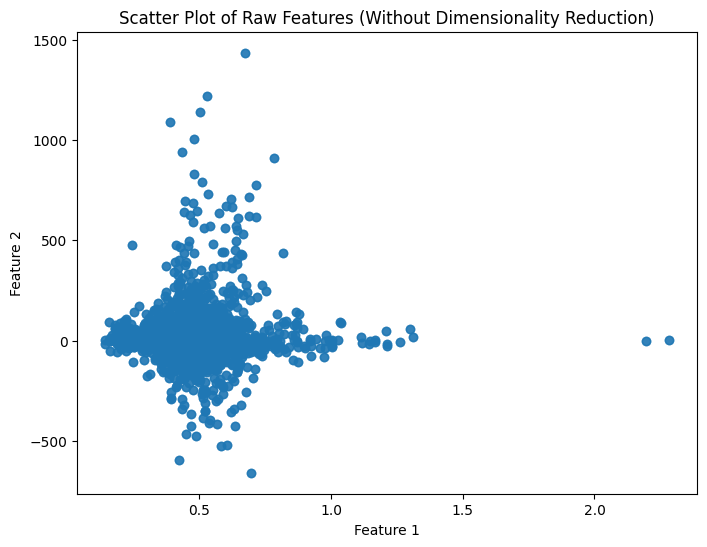

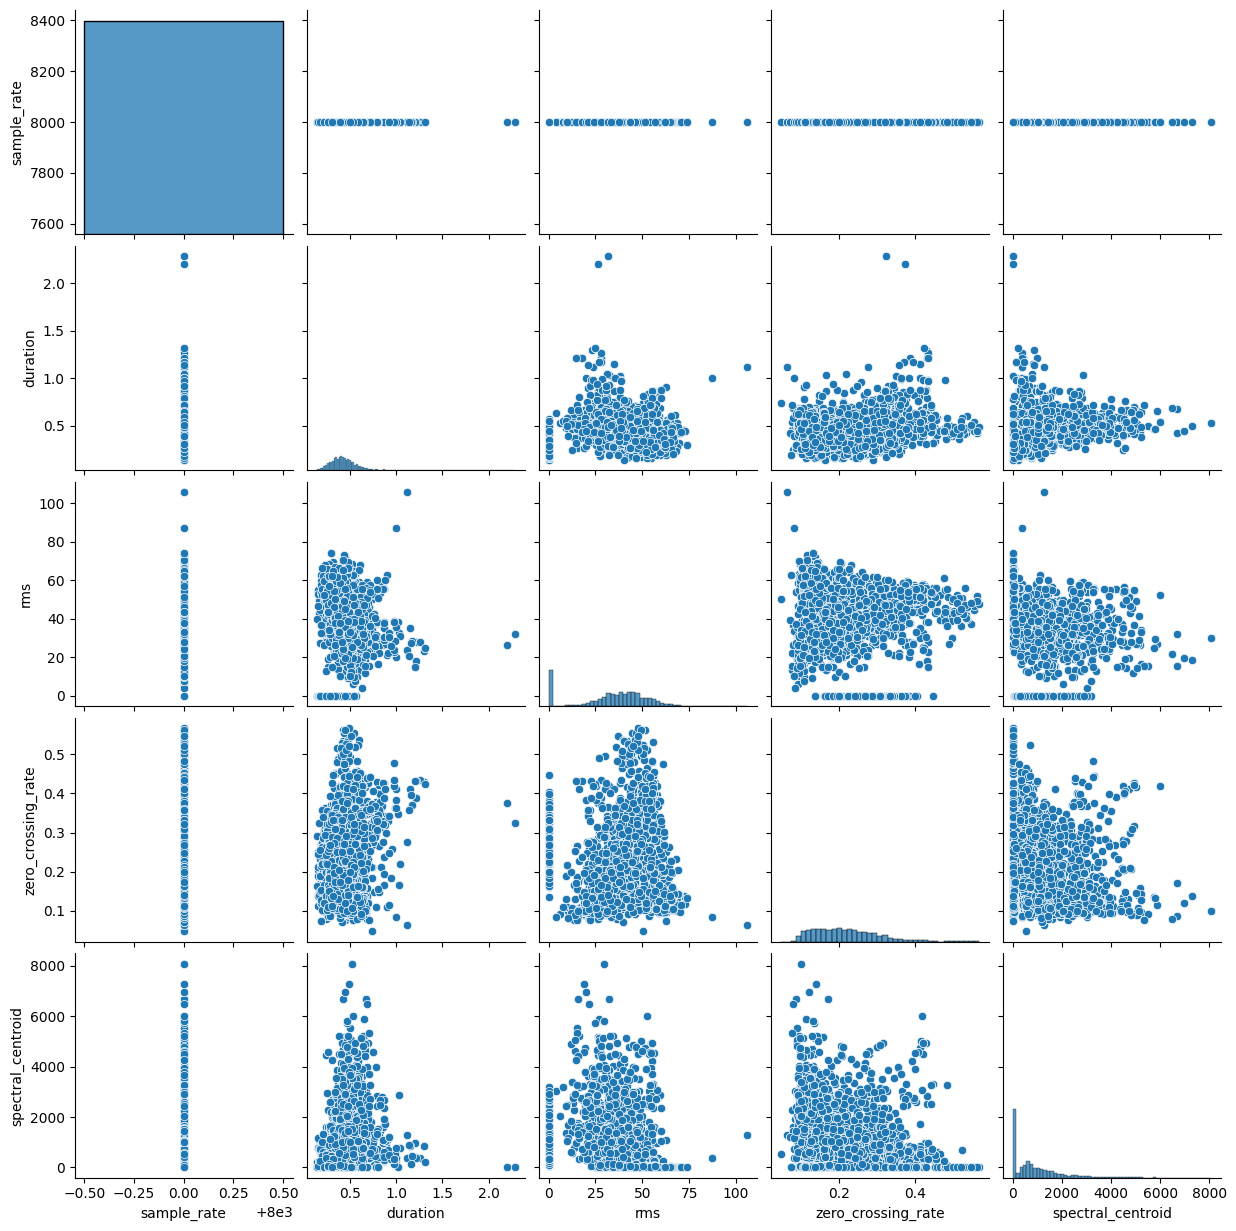

In [20]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(x=features["duration"], y=features["mel_spectrogram"],alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
feature_columns = features.select_dtypes(include=[float, int]).columns[:5]
df = features[feature_columns]

sns.pairplot(df)
plt.show()


### Why is dimensionality reduction important?
(*Document any challenges/errors from the above experiments.*)

Dimensionality reduction helps simplify data by removing unnecessary details, making it easier to work with.
It speeds up processing, improves model performance,and prevents overfitting.
When data has too many features, it can become harder to analyze, and patterns may be harder to find (curse of dimensionality).
Methods like PCA and t-SNE help by keeping the important information while reducing complexity.

In [21]:
"""Dimensionality reduction helps simplify data by removing unnecessary details, making it easier to work with.
It speeds up processing, improves model performance,and prevents overfitting.
When data has too many features, it can become harder to analyze, and patterns may be harder to find (curse of dimensionality).
Methods like PCA and t-SNE help by keeping the important information while reducing complexity."""

'Dimensionality reduction helps simplify data by removing unnecessary details, making it easier to work with.\nIt speeds up processing, improves model performance,and prevents overfitting.\nWhen data has too many features, it can become harder to analyze, and patterns may be harder to find (curse of dimensionality).\nMethods like PCA and t-SNE help by keeping the important information while reducing complexity.'

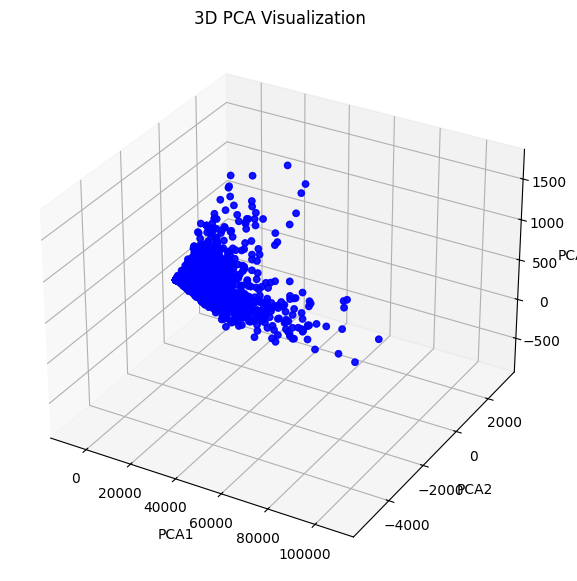

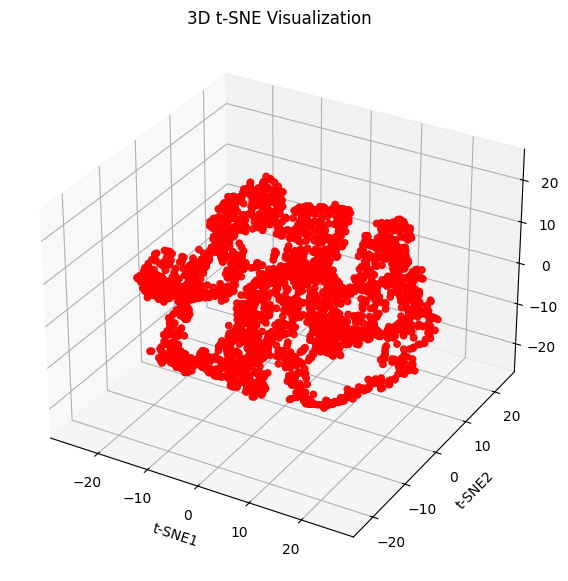

In [22]:

# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(features)

# 3D Visualization goes here

# Convert to DataFrame(pca)
df_pca = pd.DataFrame(features_pca, columns=['PCA1', 'PCA2', 'PCA3'])

# Convert to DataFrame(tsne)
df_tsne = pd.DataFrame(features_tsne, columns=['t-SNE1', 't-SNE2', 't-SNE3'])

# 3D Visualization(pca)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PCA1'], df_pca['PCA2'], df_pca['PCA3'], c='blue', alpha=0.7)

# Labels & Title
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('3D PCA Visualization')

# Show plot
plt.show()


# 3D Visualization(t-sne)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_tsne['t-SNE1'], df_tsne['t-SNE2'], df_tsne['t-SNE3'], c='red', alpha=0.7)

# Labels & Title
ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')
ax.set_zlabel('t-SNE3')
ax.set_title('3D t-SNE Visualization')

# Show plot
plt.show()



### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

PCA
PCA worked better because it captured the important patterns in the data by focusing on variations,
making it easier to separate the clusters.

In [23]:
"""PCA
PCA worked better because it captured the important patterns in the data by focusing on variations,
making it easier to separate the clusters.
"""

'PCA\nPCA worked better because it captured the important patterns in the data by focusing on variations,\nmaking it easier to separate the clusters.\n'

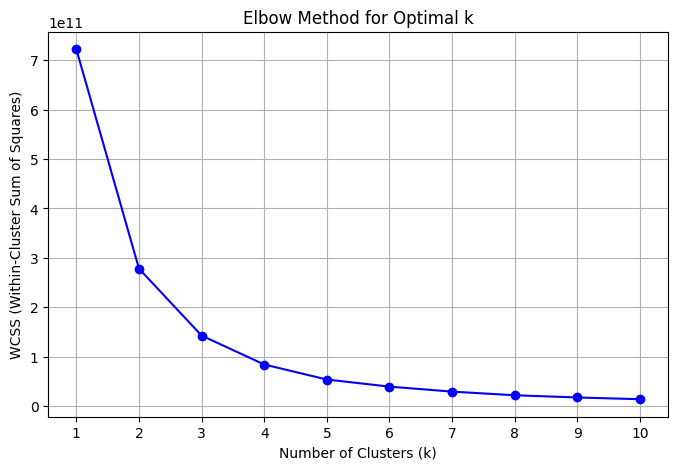

In [24]:

# Optimize number of clusters using Elbow Method
wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)  # Store inertia for each k

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

#kmeans = KMeans(None)



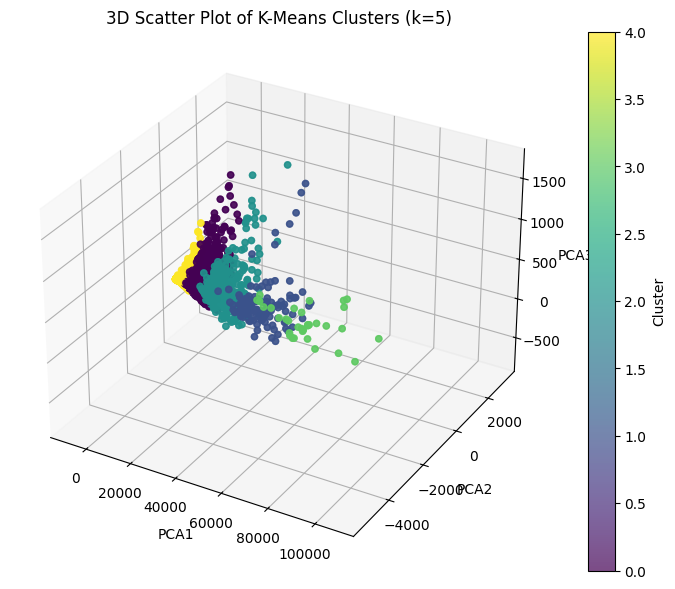

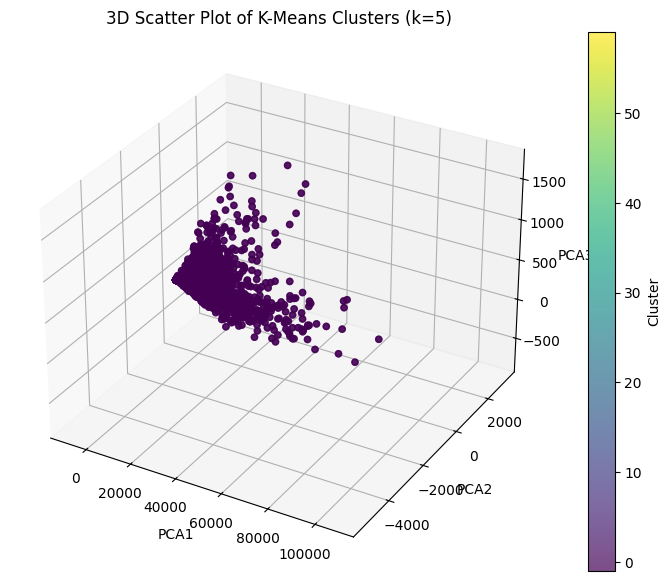

In [25]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(df_pca)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(df_pca)

# Scatter Plot for K-Means Clusters
df_pca['k-Cluster'] = kmeans_labels

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca['PCA1'], df_pca['PCA2'], df_pca['PCA3'],
                     c=df_pca['k-Cluster'], cmap='viridis', alpha=0.7)

# Labels & Title
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title(f'3D Scatter Plot of K-Means Clusters (k={optimal_k})')
plt.colorbar(scatter, label='Cluster')

plt.show()

# Scatter Plot for DBSCAN Clusters
# Convert to DataFrame
df_pca['d-Cluster'] = dbscan_labels

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca['PCA1'], df_pca['PCA2'], df_pca['PCA3'],
                     c=df_pca['d-Cluster'], cmap='viridis', alpha=0.7)

# Labels & Title
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title(f'3D Scatter Plot of K-Means Clusters (k={optimal_k})')
plt.colorbar(scatter, label='Cluster')

plt.show()



In [27]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(df_pca, kmeans_labels)
kmeans_db_index = davies_bouldin_score(df_pca, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(df_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(df_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.6167, Davies-Bouldin Index: 0.5107
DBSCAN - Silhouette Score: -0.4137, Davies-Bouldin Index: 0.8260


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

K-Means formed well-separated and compact clusters, making it the better choice for this dataset.
Its Silhouette Score (0.6164) and Davies-Bouldin Index (0.5103) indicate strong clustering.
In contrast,DBSCAN struggled, with a low Silhouette Score (-0.1644) and higher Davies-Bouldin Index (0.8010),
suggesting poor cluster formation. DBSCAN likely misclassified many points as noise or merged clusters incorrectly.
Overall,K-Means performed significantly better.

In [28]:
"""K-Means formed well-separated and compact clusters, making it the better choice for this dataset.
Its Silhouette Score (0.6164) and Davies-Bouldin Index (0.5103) indicate strong clustering.
In contrast,DBSCAN struggled, with a low Silhouette Score (-0.1644) and higher Davies-Bouldin Index (0.8010),
suggesting poor cluster formation. DBSCAN likely misclassified many points as noise or merged clusters incorrectly.
Overall,K-Means performed significantly better."""

'K-Means formed well-separated and compact clusters, making it the better choice for this dataset.\nIts Silhouette Score (0.6164) and Davies-Bouldin Index (0.5103) indicate strong clustering.\nIn contrast,DBSCAN struggled, with a low Silhouette Score (-0.1644) and higher Davies-Bouldin Index (0.8010),\nsuggesting poor cluster formation. DBSCAN likely misclassified many points as noise or merged clusters incorrectly.\nOverall,K-Means performed significantly better.'

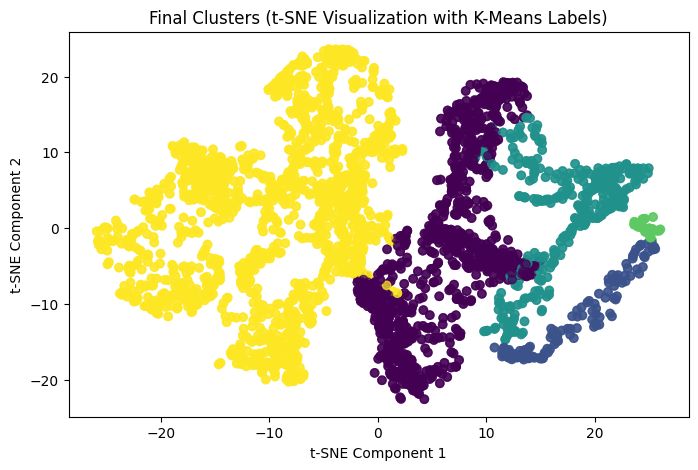

In [29]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.

# Explain why dimensionality reduction helped (or didn't) in clustering.

In [30]:
"""
Dimensionality reduction helped because it removed unnecessary details,
making the clusters clearer and easier to separate,but if the original data was already well-structured,
it might not have been needed.
"""

'\nDimensionality reduction helped because it removed unnecessary details,\nmaking the clusters clearer and easier to separate,but if the original data was already well-structured,\nit might not have been needed.\n'

# Justify why certain clustering methods worked better.

In [31]:
"""
Certain clustering methods worked better because they aligned well with the data’s structure.
K-Means performed well because the data had clear, well-separated clusters, making its centroid-based approach effective.
DBSCAN,however, struggled because it relies on density, and if the data didn’t have well-defined dense regions,
it misclassified points as noise or merged clusters incorrectly.
The choice of method matters based on how the data is distributed.
"""

'\nCertain clustering methods worked better because they aligned well with the data’s structure.\nK-Means performed well because the data had clear, well-separated clusters, making its centroid-based approach effective.\nDBSCAN,however, struggled because it relies on density, and if the data didn’t have well-defined dense regions,\nit misclassified points as noise or merged clusters incorrectly.\nThe choice of method matters based on how the data is distributed.\n'

# Relate findings to real-world clustering challenges.

In [32]:
"""
In real life,different clustering methods work better for different problems.
For example,K-Means is great for grouping customers by shopping habits because they form clear clusters.
But for spotting fraud or unusual activity,DBSCAN might be better since it can find outliers.
Our results show that the best method depends on how the data is structured,what works well in one case might not in another."""

'\nIn real life,different clustering methods work better for different problems.\nFor example,K-Means is great for grouping customers by shopping habits because they form clear clusters.\nBut for spotting fraud or unusual activity,DBSCAN might be better since it can find outliers.\nOur results show that the best method depends on how the data is structured,what works well in one case might not in another.'